# Algotrading

A pet project aimed at predicting a cryptocurrency price based on data from polymarket.com

## Problem definition


**Meta**: Try to make minimal possible solution & move to more complex ones if a simple one does not perform as we wish it to.

**A goal** is to check whether there is a correlation between crypto currencies (CC) price in the future with & polymarket polls about them.


## Available datapoints are


- CC price from Binance (target)

**Polymarket has polls of varying types**, but at its core, there is a single (Yes/No) bet. Polls of choice type are just an ordered list of (Yes/No) polls.

Some of the polls formats:
- (Choice) Price range prediction of CC at a time point
- (Choice) Min price pred. at a time point
- (Choice) When will a CC reach an all time high
- (Yes/No) Will a CC reach an all time high before some time point
- (Yes/No) Will a CC be above some price at a time point?
- etc.


**Each poll has these datapoints**:
- Total volume in USD
- End date
- For each option to make a bet on, there is a "chance" of it happening, computed using bets distribution.
- How "chance" of an event was changing over time (a graph, chart)
- Price for 100 shares. When placing a bet, user is buying shares. In the UI price per 100 shares is shown. Price of a single share varies between 0 and 1. When a bet is resolved and user made a winning bet, every share is exchanged to 1.
- Distribution of how much shares were purchased at what price for each betting option
- Comments on a poll. They can also be replies to top-level comments.
	- Content, text
	- Amount of likes
	- Shares he has on a poll. Note: multiple bets can be placed on a single poll. Total shares amount he has & for which option is shown. It means it is not shown how much money he spent, as share price has a varying price.
- 15 top holders of each option
- Recent activity: who purchased or sold shares and at what cost
- A list of related polls. Potentially, we could extract data from these polls too. For example, for a poll "Bitcoin above 105,000 on January 31?" its related bet can be "Will Bitcoin reach 110_000 by January 31, 2025"

**We can view top users** by their betting volume & profit. **Their bets could be mimiced**.
Looks like a bot to me: https://polymarket.com/profile/0x42a6ddf7cf7032972b0bfe32775e8109c5171b64?tab=activity


## Visual analysis


I've placed 2 charts side my side: BCT Price and Polymarket confidence in BTC hitting a price of 120k by March 31. Visually it can be seen that Polymarket roughly mimics the BTC price trend, which had never reached this price point, typically being in a range of 95k-105k.

Notably, other polymerket polls - 110k, 130k, 150k, 200k have a similar shape, where bigger the poll price (200k), less similar (mimicing its up's and down's) it is to a BTC price at that time.

Binance BTC Price Chart            |  Market confidence in "BTC will hit 120k by March 31" 
:-------------------------:|:-------------------------:
![image.png](../static/1_binance_btc_chart.png)  |  ![image.png](../static/1_polymarket_BTC_hit_120k.png)


Next observation is, that polls that bet on a lower outcome than the current price have a negative correlation, meaning that when more people bet "Yes" on 120k, more people vote "No" on 80k.

Market confidence in "BTC will hit 120k by March 31"
![image.png](../static/1_polymarket_BTC_hit_120k.png)  

Market confidence in "BTC will hit 80k by March 31"
![image.png](../static/1_polymarket_BTC_hit_80k.png)


## Short-term correlation of BTC price and polymarket polls

In [48]:
import pandas as pd

from polymarket_datasets import load_pm_dataset

pm_data = load_pm_dataset('2_pm_BTC_1d.csv')

[v.label for v in pm_data]

['200',
 '150',
 '140',
 '130',
 '120',
 '110',
 '105',
 '100',
 '90',
 '85',
 '80',
 '70',
 '60',
 '50']

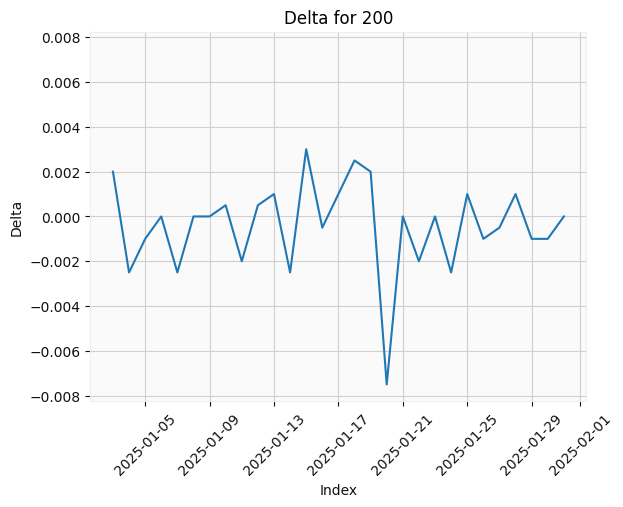

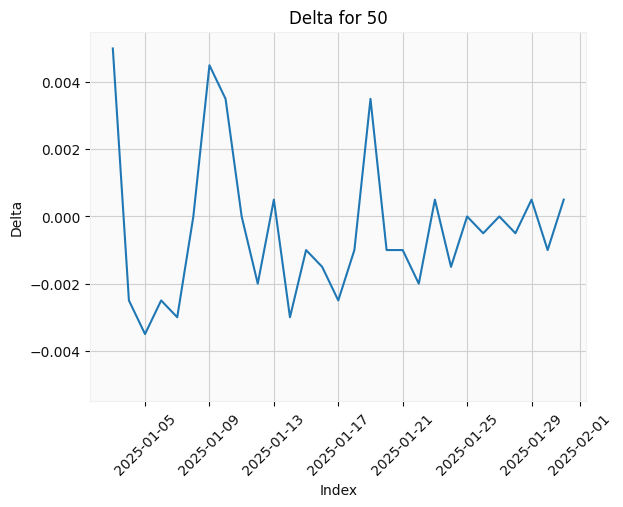

In [49]:
import matplotlib.pyplot as plt
import numpy as np

from polymarket_datasets import PMDataset


def plot_pm_delta(data: PMDataset):
    delta_abs_max = max((data.delta.max(), abs(data.delta.min()))) * 1.1

    plt.plot(data.index, data.delta)
    plt.xticks(rotation=45)
    plt.title(f"Delta for {data.label}")
    plt.xlabel("Index")
    plt.ylabel("Delta")
    plt.ylim((-delta_abs_max, delta_abs_max))
    plt.show()


plot_pm_delta(pm_data[0])
plot_pm_delta(pm_data[-1])

In [51]:
from binance import Client

from binance_datasets import load_binance_dataset


pm_110_data = pm_data[5]

start_date = min(*pm_data, key=lambda d: d.date_from).date_from.isoformat()
end_date = max(*pm_data, key=lambda d: d.date_to).date_to.isoformat()

binance_df = load_binance_dataset("BTCUSDT", Client.KLINE_INTERVAL_1DAY, start_date, end_date)

print(f"PM datapoints: {len(pm_110_data.delta)}. Start: {start_date}, end: {end_date}")
print(binance_df.info())

binance_df.tail()


PM datapoints: 29. Start: 2025-01-03T00:00:00, end: 2025-02-01T00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2025-01-03 to 2025-02-01
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open                          30 non-null     float64       
 1   High                          30 non-null     float64       
 2   Low                           30 non-null     float64       
 3   Close                         30 non-null     float64       
 4   Volume                        30 non-null     float64       
 5   Close Time                    30 non-null     datetime64[ns]
 6   Quote Asset Volume            30 non-null     float64       
 7   Number of Trades              30 non-null     int64         
 8   Taker Buy Base Asset Volume   30 non-null     float64       
 9   Taker Buy Quote Asset Volume  30 non-null     float64       
 10  Ignore  

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,delta
Open Time,,,,,,,,,,,,
2025-01-28,102082.83,103800.00,100272.68,101335.52,22022.05765,2025-01-28 23:59:59.999,2.253977e+09,5428644,10756.64741,1.101358e+09,0,-747.31
2025-01-29,101335.52,104782.68,101328.01,103733.24,23155.35802,2025-01-29 23:59:59.999,2.380384e+09,5189699,11675.17182,1.200637e+09,0,2397.72
2025-01-30,103733.25,106457.44,103278.54,104722.94,19374.07472,2025-01-30 23:59:59.999,2.038113e+09,3990075,10140.92834,1.066933e+09,0,989.69
2025-01-31,104722.94,106012.00,101560.00,102429.56,21983.18193,2025-01-31 23:59:59.999,2.282174e+09,4331904,10697.39968,1.111486e+09,0,-2293.38
2025-02-01,102429.56,102783.71,100279.51,100635.65,12290.95747,2025-02-01 23:59:59.999,1.250354e+09,2588786,5625.89331,5.725400e+08,0,-1793.91


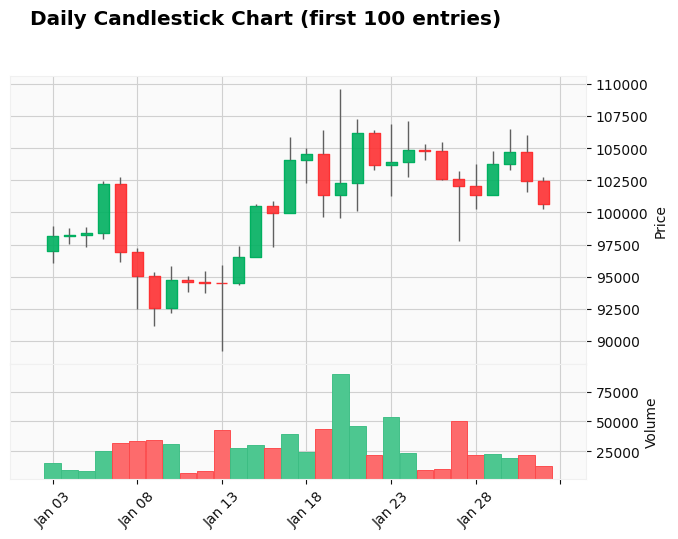

In [52]:
import mplfinance as mpf

mpf.plot(binance_df[0:100], type='candle', volume=True, title="Daily Candlestick Chart (first 100 entries)", style='yahoo')


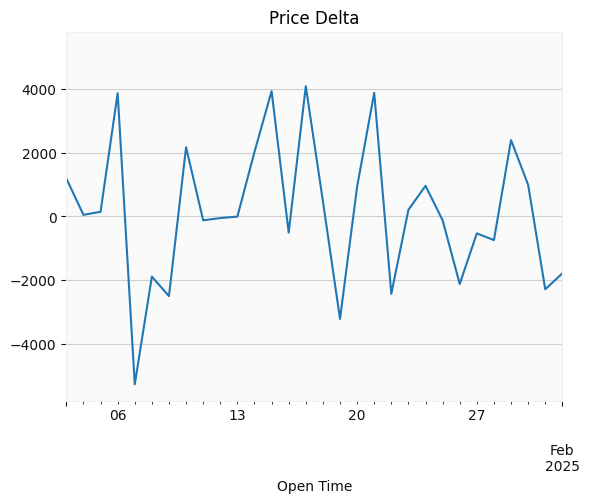

In [53]:
import numpy as np

ax = binance_df['delta'].plot(title='Price Delta')

lim = np.max(np.abs(binance_df['delta']))
lim = lim * 1.1

plt.ylim(-lim, lim)
plt.show()

In [54]:
from sklearn.preprocessing import MaxAbsScaler

deltas = []
for data in pm_data:

    binance_delta = binance_df.loc[data.index, "delta"]

    scaler = MaxAbsScaler()
    delta = scaler.fit_transform(data.delta.reshape(-1, 1)).flatten()
    binance_delta = scaler.fit_transform(binance_delta.values.reshape(-1, 1)).flatten()

    deltas.append({"data": data, "delta": delta, "BTC_delta": binance_delta})


deltas[0]["delta"][0:100]

array([ 0.26666667, -0.33333333, -0.13333333,  0.        , -0.33333333,
        0.        ,  0.        ,  0.06666667, -0.26666667,  0.06666667,
        0.13333333, -0.33333333,  0.4       , -0.06666667,  0.13333333,
        0.33333333,  0.26666667, -1.        ,  0.        , -0.26666667,
        0.        , -0.33333333,  0.13333333, -0.13333333, -0.06666667,
        0.13333333, -0.13333333, -0.13333333,  0.        ])

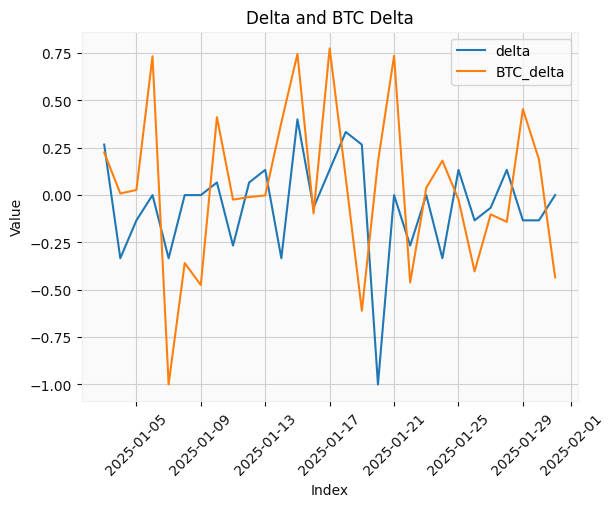

In [55]:

plt.plot(deltas[0]["data"].index, deltas[0]["delta"], label="delta")
plt.plot(deltas[0]["data"].index, deltas[0]["BTC_delta"], label="BTC_delta")
plt.title("Delta and BTC Delta")
plt.xlabel("Index")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [57]:
corr_offsets = range(-3, 3 + 1)
corr_data = []


for d in deltas:

    data: PMDataset = d["data"]
    print(f"{len(data.open)=}")

    delta = d["delta"]
    BTC_delta = d["BTC_delta"]
    col_corr_data = []
    for offset in corr_offsets:
        offset_delta = np.roll(delta, offset)
        offset_BTC_delta = BTC_delta

        if offset > 0:
            offset_delta = offset_delta[offset:]
            offset_BTC_delta = BTC_delta[offset:]
        elif offset < 0:
            offset_delta = offset_delta[:offset]
            offset_BTC_delta = BTC_delta[:offset]

        correlation_with_offset = np.corrcoef(offset_BTC_delta, offset_delta)[0, 1]

        col_corr_data.append(correlation_with_offset)
    corr_data.append(col_corr_data)

corr_data[5]

len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=14
len(data.open)=3
len(data.open)=10
len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=29
len(data.open)=29


/home/nur/Projects/algotrading/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nur/Projects/algotrading/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/nur/Projects/algotrading/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/nur/Projects/algotrading/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nur/Projects/algotrading/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[np.float64(0.28073868349618236),
 np.float64(-0.07618346780984997),
 np.float64(-0.1472855464319162),
 np.float64(0.9013388047583928),
 np.float64(-0.0628963939158928),
 np.float64(-0.2209073536593423),
 np.float64(0.15097720340348375)]

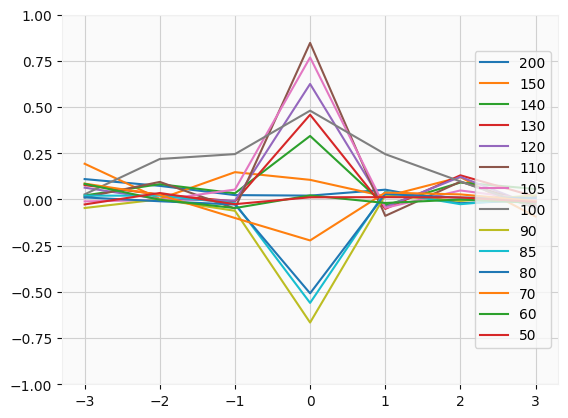

In [39]:
for i, d in enumerate(deltas):
    plt.plot(corr_offsets, corr_data[i], label=d["data"].label)

plt.legend(loc="right")

plt.ylim(-1, 1)

# Show the plot
plt.show()

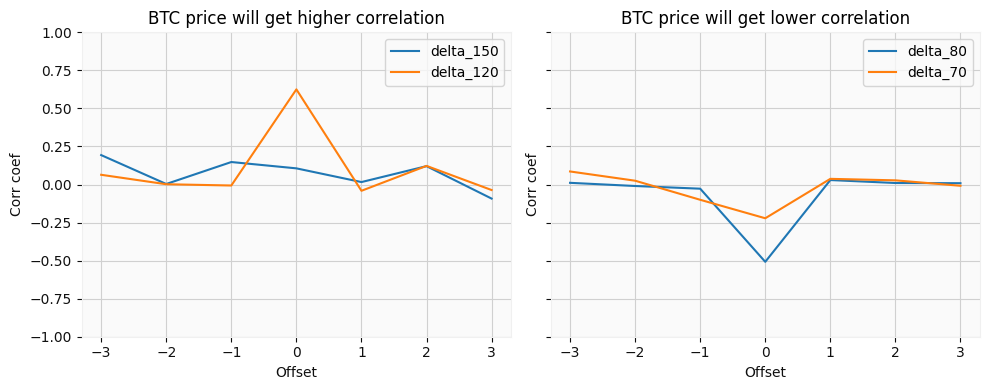

In [40]:
# Create two side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True, sharex=True)

axes[0].plot(corr_offsets, corr_data[1], label="delta_150")
axes[0].plot(corr_offsets, corr_data[4], label="delta_120")
axes[0].set_title("BTC price will get higher correlation")
axes[0].set_xlabel("Offset")
axes[0].set_ylabel("Corr coef")
axes[0].legend()

axes[1].plot(corr_offsets, corr_data[10], label="delta_80")
axes[1].plot(corr_offsets, corr_data[11], label="delta_70")
axes[1].set_title("BTC price will get lower correlation")
axes[1].set_xlabel("Offset")
axes[1].set_ylabel("Corr coef")
axes[1].legend()

plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

In [62]:

def plot_delta_correlation(pm_data: list[PMDataset], interval: str, corr_amplitude: int = 3):

    # Load data from binance
    start_date = min(*pm_data, key=lambda d: d.date_from).date_from.isoformat()
    end_date = max(*pm_data, key=lambda d: d.date_to).date_to.isoformat()

    binance_df = load_binance_dataset("BTCUSDT", interval, start_date, end_date)

    # Merge pm and binance data
    pm_datasets = []
    deltas = []
    binance_deltas = []
    for data in pm_data:
        if len(data.open) < corr_amplitude * 2:
            print(f"Skipping {data.label} due to insufficient data")
            continue

        binance_delta = binance_df.loc[data.index, "delta"]

        scaler = MaxAbsScaler()

        # delta = scaler.fit_transform(data.delta.reshape(-1, 1)).flatten()
        deltas.append(data.delta)

        binance_delta = scaler.fit_transform(binance_delta.values.reshape(-1, 1)).flatten()
        binance_deltas.append(binance_delta)

        pm_datasets.append(data)

    # Compute correlations with offset
    corr_offsets = range(-corr_amplitude, corr_amplitude+1)
    corr_data = []
    for i in range(len(pm_datasets)):
        data: PMDataset = pm_datasets[i]
        delta = deltas[i]
        BTC_delta = binance_deltas[i]

        col_corr_data = []
        for offset in corr_offsets:
            offset_delta = np.roll(delta, offset)
            offset_BTC_delta = BTC_delta

            if offset > 0:
                offset_delta = offset_delta[offset:]
                offset_BTC_delta = BTC_delta[offset:]
            elif offset < 0:
                offset_delta = offset_delta[:offset]
                offset_BTC_delta = BTC_delta[:offset]

            correlation_with_offset = np.corrcoef(offset_BTC_delta, offset_delta)[0, 1]

            col_corr_data.append(correlation_with_offset)
        corr_data.append(col_corr_data)

    # Plot the data
    fig, axes = plt.subplots(nrows=len(pm_datasets), ncols=2, figsize=(10, 40))

    for i, data in enumerate(pm_datasets):

        # Plot offsetted correlations 
        axes[i][0].plot(corr_offsets, corr_data[i], label=data.label)
        axes[i][0].set_title("BTC price will get higher correlation")
        axes[i][0].set_xlabel("Offset")
        axes[i][0].set_ylabel("Corr coef")
        axes[i][0].set_ylim(-1, 1)
        axes[i][0].legend()

        # Plot polymarket probability
        axes[i][1].plot(data.index, data.open, label=f'open_{data.label}')
        axes[i][1].set_title("...")
        axes[i][1].set_xlabel("...")
        axes[i][1].set_xticks(axes[i][1].get_xticks())
        axes[i][1].set_xticklabels(axes[i][1].get_xticklabels(), rotation=45)
        axes[i][1].set_ylabel("...")
        axes[i][1].legend()
    
    plt.tight_layout()
    plt.show()


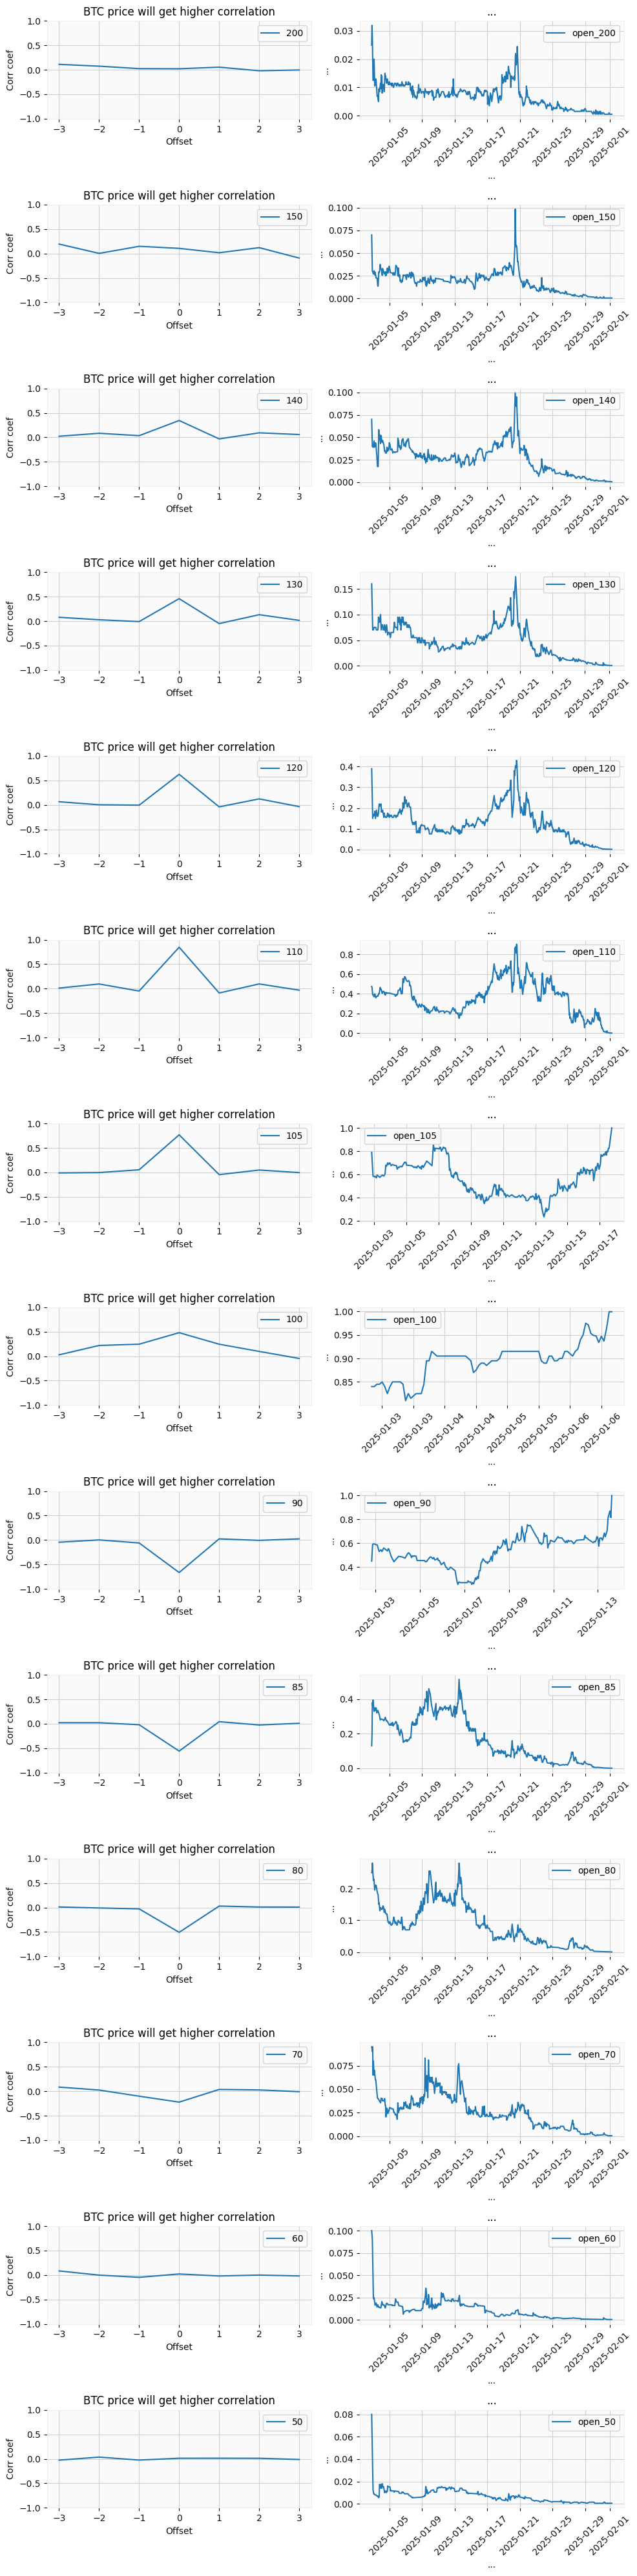

In [60]:

pm_df = load_pm_dataset('2_pm_BTC_1h.csv')
plot_delta_correlation(pm_df, Client.KLINE_INTERVAL_1HOUR)

Skipping 100 due to insufficient data


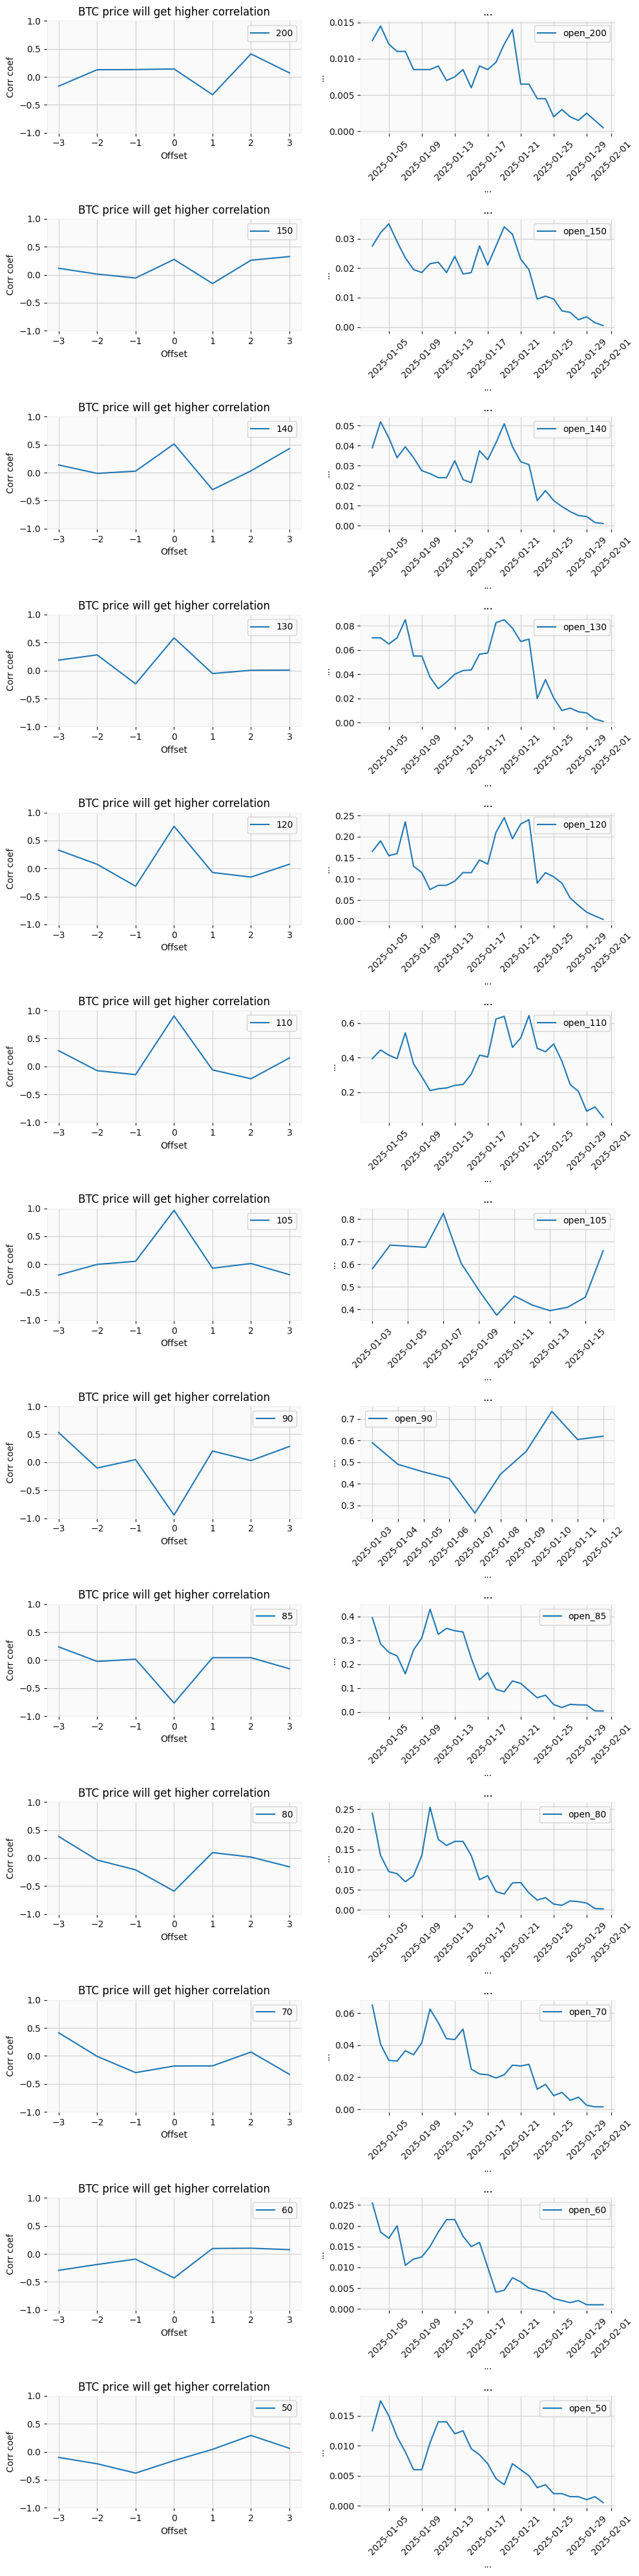

In [63]:

pm_df = load_pm_dataset('2_pm_BTC_1d.csv')
plot_delta_correlation(pm_df, Client.KLINE_INTERVAL_1DAY)

### Correlation plot interpretation

Plot was created using:
1. BTC price, that at the selected time interval was around 95k to 105k
2. Probability distribution of polymarket polls that BTC price will be 150k, 120k, 80k, 70k by March 31.

Plot is showing correlation coefficients on y axis between:
1. How much did BTC price change on a given day.
2. How much did probability distribution change on a given day.

With an offset value that is plotted on x axis.

At offset 0, there is a high positive correlation on bets that BTC will grow, and high negative correlation that BTC will loose in its price, which can indicate that market reponds to BTC's price change moderately reactively. Meaning that it mostly reacts to its changes day-by-day, which might indicate that there is no predictive power in this probability distribution.

At other offsets, the corr coef are negligibly small, though a sinusoid-like pattern is noticable.

Upd: This correlation is caused by noise traders.

TODO: Make plots with bigger and smaller time intervals.


### Next